<a href="https://colab.research.google.com/github/piyu18/Pytorch-deep-learning/blob/main/PyTorch_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import torch
from torch import nn 
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.12.1+cu113'

### Data Preparation
Let's create some dummy data for linear regression, `y = mX+b`

In [2]:
weight = 0.5 # m value in y = mX+b
bias = 0.3 # b
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3100],
         [0.3200],
         [0.3300],
         [0.3400],
         [0.3500],
         [0.3600],
         [0.3700],
         [0.3800],
         [0.3900]]))

In [3]:
len(X), len(y)

(50, 50)

### Train Test Split

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [5]:
def plt_predictions(train_data=X_train,
                    train_label=y_train,
                    test_data=X_test,
                    test_label=y_test,
                    predictions=None):
  '''
  Plt training_data, test data and compare predictions
  '''
  plt.figure(figsize=(8,6))
  # Plot training data in blue
  plt.scatter(train_data, train_label, c='b', s=6, label='Train data')

  # Plot test data in green
  plt.scatter(test_data, test_label, c='g', s=6, label='Test data')

  # If prediction is there
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=6, label='Predictions')
  
  plt.legend(prop={"size": 16})

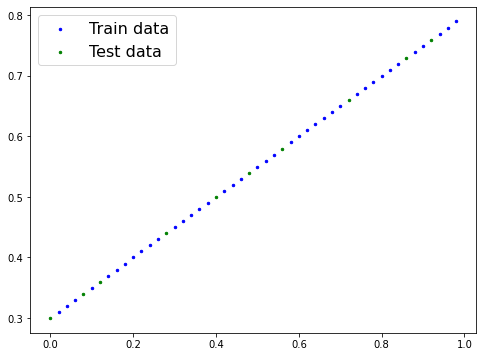

In [6]:
plt_predictions()

### PyTorch Modules
| PyTorch module | Use |
| ----- | ----- |
| `torch.nn` | It contains all the building blocks for computational graph |
| `torch.nn.Parameter` | It stores tensors that can be used with nn.Module. If the parameter requires gradient then `requires_grad=True`, default is True |
| `torch.nn.Module` | It is the base class for all NN Module, all the building blocks for NN are subclasses.  If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented. |
|`torch.optim` | It contains various optimization algorithms|



### Build Model

In [7]:
# Linear Regression Model Class
class LinearRegressionModel(nn.Module): # nn.Module is the base class for all NN Modules
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # start with random weights
        requires_grad=True, # if gradient is required
        dtype=torch.float32 # default is float32
    ))

    self.bias = nn.Parameter(torch.randn(1, # start with random weights
        requires_grad=True, # if gradient is required
        dtype=torch.float32 # default is float32
    ))

  # Forward defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is the input data (e.g. training/testing features)
     return self.weights * x + self.bias # it's linear regression formula (y = m*x + b)


### Check the content of the Model

In [8]:
# Set manual seed
torch.manual_seed(42)

# Create an instance of the model
model_1 = LinearRegressionModel()

# Check the parameters
model_1.parameters() # gives generator object

list(model_1.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get what model contains using `state_dict()`

In [9]:
model_1.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Make Prediction using `torch.inference_mode()`

In [10]:
# Make prediction with the model
with torch.inference_mode(): 
    y_preds = model_1(X_test)

In [11]:

# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.4184],
        [0.1557],
        [0.2635],
        [0.4386],
        [0.1288],
        [0.2231],
        [0.3712],
        [0.3174],
        [0.2904],
        [0.1692]])


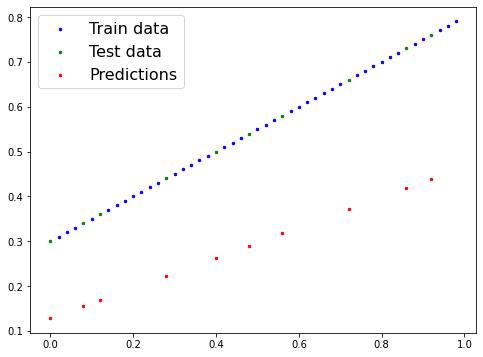

In [12]:
plt_predictions(predictions=y_preds)

These predictions look very bad. Right now our model is making predictions using random parameters. To fix this we can use loss funnction and optimizers

### Loss function & Optimizers in PyTorch
* **Loss function** : Measures how well your model is performing. Lower the value better is the model. PyTorch has plenty of built in loss functions in `torch.nn`.

For example MAE for regression problem(`torch.nn.L1Loss()`). For Classification binary cross entropy(`torch.nn.BCELoss()`)

`nn.L1Loss()`Creates a criterion that measures the mean absolute error (MAE) between each element in the input x and target y. 

`nn.BCELoss()`Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities:

* **Optimizer** : Tells the model how to update the internal parameters to lower the loss. Various optimization functions are present in `torch.optim`.

For Example: `torch.optim.SGD()`, `torch.optim.Adam()`

In [13]:
# Create loss function
loss_fun = nn.L1Loss() 

# Create the optimizer
optimizer = torch.optim.SGD(
    params=model_1.parameters(), 
    lr = 0.01
)

Let's put all steps together and try to improve our model

In [14]:
torch.manual_seed(42)
epochs = 100

# Create empty loss list to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  model_1.train()

  # Forward pass on train data using the forward() method
  y_pred = model_1(X_train)

  # Calculate loss
  loss = loss_fun(y_pred, y_train)

  # Zero grad of the optimizer
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Process the optimizer
  optimizer.step()

  ## Testing

  # Put the model in evaluation mode
  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)

    # Calculate loss on test data
    test_loss = loss_fun(test_pred, y_test.type(torch.float))

    if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.2531720697879791 | MAE Test Loss: 0.2311546355485916 
Epoch: 10 | MAE Train Loss: 0.1279716193675995 | MAE Test Loss: 0.10896619409322739 
Epoch: 20 | MAE Train Loss: 0.017217198386788368 | MAE Test Loss: 0.015951961278915405 
Epoch: 30 | MAE Train Loss: 0.009797533042728901 | MAE Test Loss: 0.010579342022538185 
Epoch: 40 | MAE Train Loss: 0.0051111155189573765 | MAE Test Loss: 0.0053997160866856575 
Epoch: 50 | MAE Train Loss: 0.010711098089814186 | MAE Test Loss: 0.0019882977940142155 
Epoch: 60 | MAE Train Loss: 0.010711098089814186 | MAE Test Loss: 0.0019882977940142155 
Epoch: 70 | MAE Train Loss: 0.010711098089814186 | MAE Test Loss: 0.0019882977940142155 
Epoch: 80 | MAE Train Loss: 0.010711098089814186 | MAE Test Loss: 0.0019882977940142155 
Epoch: 90 | MAE Train Loss: 0.010711098089814186 | MAE Test Loss: 0.0019882977940142155 


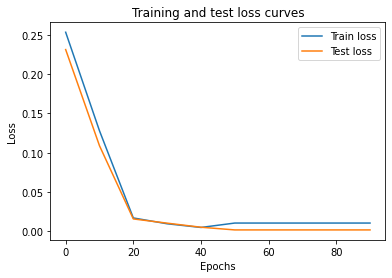

In [15]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [16]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.4920])), ('bias', tensor([0.2933]))])

And the original values for weights and bias are:
weights: 0.5, bias: 0.3


In [17]:
# 1. Set the model in evaluation mode
model_1.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_1(X_test)
y_preds

tensor([[0.7164],
        [0.3327],
        [0.4901],
        [0.7459],
        [0.2933],
        [0.4311],
        [0.6475],
        [0.5688],
        [0.5295],
        [0.3523]])

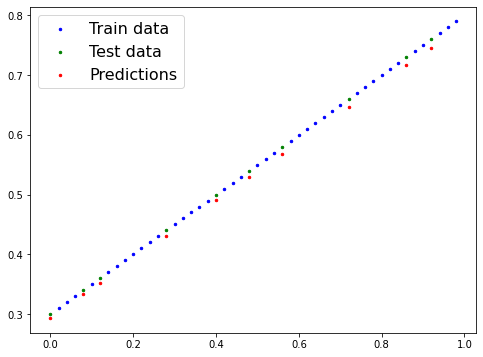

In [19]:
plt_predictions(predictions=y_preds)

From the plot we can see that our predicted values are much closer to the actual test data

### Saving & loading of Model

* **`torch.save`:** Saves a serialized object to disk. This function uses Python’s pickle utility for serialization. Models, tensors, and dictionaries of all kinds of objects can be saved using this function.

* **`torch.load`:** Uses pickle’s unpickling facilities to deserialize pickled object files to memory.

* **`torch.nn.Module.load_state_dict`:**  Loads a model’s parameter dictionary using a deserialized state_dict.


In [20]:
from pathlib import Path

# Create directory
MODEL_PATH = Path('MODELS')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create modelsave path
MODEL_NAME = 'model1'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state_dict
torch.save(obj = model_1.state_dict(),
           f = MODEL_SAVE_PATH)

In [21]:
!ls -l MODELS/model1

-rw-r--r-- 1 root root 1063 Nov 22 14:03 MODELS/model1


### Loading a saved pytorch model

In [22]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_1 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [23]:
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_1(X_test) 

In [24]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])